# Data loading

In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=54b954c07cccbd1b0b3e2ecdc22dff8f330f4cd61ffa651db9ae5b4e3c636d21
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
import os
user = ''
key = ''
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

100% 3.49G/3.50G [01:05<00:00, 48.4MB/s]
100% 3.50G/3.50G [01:05<00:00, 57.2MB/s]


In [0]:
!unzip tensorflow-speech-recognition-challenge.zip

Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                


# Data unpacking


In [0]:
!pip install pyunpack
!pip install patool

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5163 sha256=454502eff0d3123ed7b9ee5912c4e427b522257cd9f855519e7f263041000c73
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack
     |████████████████████████████████| 81kB 7.3MB/s 


In [0]:
from pyunpack import Archive
import os
import shutil
import time

Archive('train.7z').extractall('/content/')
Archive('sample_submission.7z').extractall('/content/')
#Archive('test.7z').extractall('/content/')

# import libraries

In [0]:
# data path
TRAIN_AUDIO_PATH = "/content/train/audio/"

In [0]:
# install library for audio/signal analysis 
!pip install librosa

In [0]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# from waves to spectrograms
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Creating a data frame

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

labels = os.listdir(TRAIN_AUDIO_PATH)
# creating data map
data_map = {}
for ind, label in enumerate(labels):
    data_path = TRAIN_AUDIO_PATH + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()

dict_keys(['/content/train/audio/go', '/content/train/audio/marvin', '/content/train/audio/eight', '/content/train/audio/house', '/content/train/audio/nine', '/content/train/audio/happy', '/content/train/audio/off', '/content/train/audio/five', '/content/train/audio/bed', '/content/train/audio/two', '/content/train/audio/bird', '/content/train/audio/stop', '/content/train/audio/up', '/content/train/audio/no', '/content/train/audio/sheila', '/content/train/audio/right', '/content/train/audio/down', '/content/train/audio/tree', '/content/train/audio/_background_noise_', '/content/train/audio/left', '/content/train/audio/on', '/content/train/audio/dog', '/content/train/audio/one', '/content/train/audio/four', '/content/train/audio/three', '/content/train/audio/six', '/content/train/audio/seven', '/content/train/audio/wow', '/content/train/audio/yes', '/content/train/audio/cat', '/content/train/audio/zero'])

In [0]:
# creating data frame
data_map = {}
for ind, label in enumerate(labels):
    data_path = TRAIN_AUDIO_PATH + label
    data_map[ind] = label, os.listdir(data_path), ind

    
df = pd.DataFrame(data_map.values(), 
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])

#https://stackoverflow.com/questions/32468402/how-to-explode-a-list-inside-a-dataframe-cell-into-separate-rows
df.reset_index(inplace=True)
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
#print(df_new["label_name"].value_counts())
df_new.head()

,label_name,label,path
0,go,0,6f5b4d3d_nohash_0.wav
1,go,0,11321027_nohash_0.wav
2,go,0,7e556a2c_nohash_0.wav
3,go,0,10ace7eb_nohash_1.wav
4,go,0,36050ef3_nohash_0.wav


In [0]:
# labels for training - https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data
train_classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

# df with training classes
# https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values
df1 = df_new.loc[df_new['label_name'].isin(train_classes)].reset_index(drop=True)

# alignment labels for training classes
keys = np.unique(df1['label'])
values = [l for l in range(len(train_classes))]
df1['label'] = df1['label'].replace(keys, values)

classes_for_subbmition = dict(zip(values, train_classes))
classes_for_subbmition[10] = "unknown"


# df as class "unknown" or "silence"
df2 = df_new[~df_new['label_name'].isin(train_classes)].reset_index(drop=True)
df2['label'] = None
df2 = df2.drop(df2[df2['label'].isnull()].sample(38500,random_state=120).index)
df2['label'] = 10

# df for training
train_df = df1.append(df2, ignore_index=True).reset_index(drop=True)
train_df.to_csv(r'speech_commands_dataset_train_labels.csv', index=True)
print(train_df.groupby(["label", "label_name"]).count())
train_df.head()

                  path
label label_name      
0     go          2372
1     off         2357
2     stop        2380
3     up          2375
4     no          2375
5     right       2367
6     down        2359
7     left        2353
8     on          2367
9     yes         2377
10    bed          100
      bird         108
      cat          130
      dog          117
      eight        139
      five         127
      four         146
      happy        113
      house        132
      marvin        97
      nine         138
      one          145
      seven        126
      sheila       107
      six          147
      three        154
      tree          99
      two          159
      wow          104
      zero         158


,label_name,label,path
0,go,0,6f5b4d3d_nohash_0.wav
1,go,0,11321027_nohash_0.wav
2,go,0,7e556a2c_nohash_0.wav
3,go,0,10ace7eb_nohash_1.wav
4,go,0,36050ef3_nohash_0.wav


# DataGenerator

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms

import cv2


In [0]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, df, data_path, transforms=None):
        self.df = df
        self.data_path = data_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        signal_path = self.data_path + self.df.iloc[idx, 0] + "/" + self.df.iloc[idx, 2]
        samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        img = cv2.resize(spectrogram, (256, 256))
        img = np.stack((img,)*3, axis=-1).astype(np.float32())
        label =  self.df.iloc[idx, 1]
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, label

In [0]:
# Split data into training and validation
train_df, val_df = train_test_split(train_df, stratify=train_df.label, test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df.label, test_size=0.1)
print(train_df.shape, val_df.shape, test_df.shape)


# Augmentations for data
aug = transforms.Compose([#transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

# Speech Commands dataset
train_dataset = SpeechCommandsDataset(df=train_df,
                            data_path=TRAIN_AUDIO_PATH,
                            transforms=aug)

val_dataset = SpeechCommandsDataset(df=val_df,
                           data_path=TRAIN_AUDIO_PATH,
                           transforms=aug)

test_dataset = SpeechCommandsDataset(df=test_df,
                           data_path=TRAIN_AUDIO_PATH,
                           transforms=aug)


# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

(21244, 3) (2623, 3) (2361, 3)


## Let's look at the batch of training data.

torch.Size([32, 3, 256, 256]) torch.Size([32])


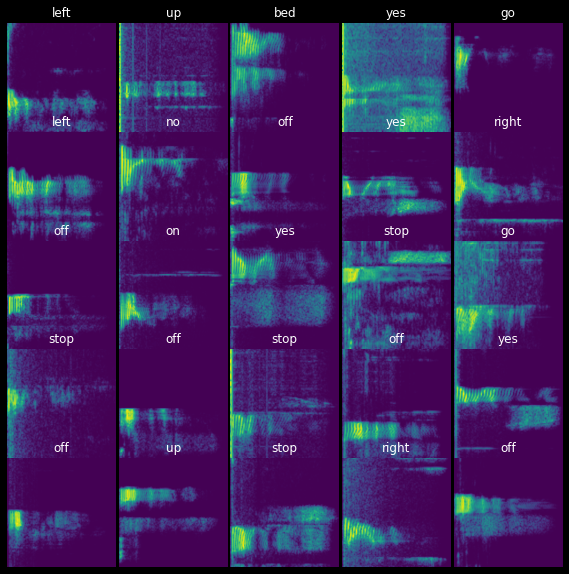

In [0]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

def show_aug(inputs, labels, nrows=5, ncols=5):
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        #https://stackoverflow.com/questions/23470450/create-a-dictionary-from-groupby-object-python
        l_map = train_df.groupby(["label", "label_name"]).count()
        d = {k:list(l_map.loc[k].index) for k in l_map.index.levels[0]}
    
        plt.figure(figsize=(10, 10))
        plt.subplots_adjust(wspace=0., hspace=0.)
        i_ = 0
    
        for idx in range(len(inputs)):

            l = int(labels[idx])
            plt.subplot(nrows, ncols, i_+1).set_title(d[l][0])
            plt.imshow(inputs[idx][0,:]); 
            plt.axis('off')
            i_ += 1

        return plt.show()

    
# get a batch of training data
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)    
    
# plot 
show_aug(data, labels)

# Training neural net

In [0]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=b816495ddb80d28b57650e84420e5f54d80f3d22eeb6370c5d5076a0a8885dfd
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
import sys
package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [0]:
from efficientnet_pytorch import EfficientNet

# Hyper parameters
num_epochs = 3
num_classes = len(train_df["label"].value_counts())

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
model = model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [0]:
# Loss and optimizer
optimizer = torch.optim.Adamax(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [0]:
%%time 

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        print(time.ctime())
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            
            indicies = torch.argmax(prediction, 1)
            res = indicies == y_gpu
            correct_samples += torch.sum(res)
            total_samples += y.shape[0]
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, num_epochs)
torch.save(model.state_dict(), 'model.pt')

Wed Apr 15 03:04:36 2020
Average loss: 0.382596, Train accuracy: 0.871681, Val accuracy: 0.930995
Wed Apr 15 04:44:07 2020
Average loss: 0.144446, Train accuracy: 0.953257, Val accuracy: 0.942432
Wed Apr 15 06:31:20 2020
Average loss: 0.098896, Train accuracy: 0.967332, Val accuracy: 0.939764
CPU times: user 18min 57s, sys: 1h 44min 54s, total: 2h 3min 51s
Wall time: 5h 18min 39s


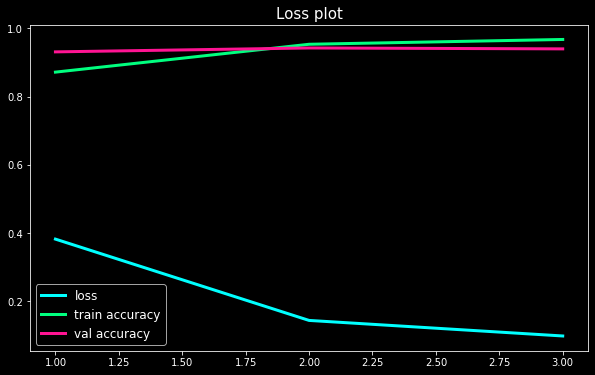

In [0]:
import matplotlib.pyplot as plt

x = np.arange(1, 4)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, loss_history, label='loss',lw=3, c="cyan")
plt.plot(x, train_history, label='train accuracy', lw=3, c="springgreen")
plt.plot(x, val_history, label='val accuracy', lw=3, c="deeppink")

plt.title("Loss plot", fontsize=15)
plt.legend(fontsize=12)

plt.show()

# **Test**

In [0]:
pred_Y = []
Y = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for p, l in zip(predicted, labels):
            #print(p, l)
            pred_Y.append(p.detach().cpu())
            Y.append(l.detach().cpu())
          
    print('Test Accuracy:  {} %'.format(100 * correct / total))

Test Accuracy:  95.12918254976705 %


# Сonfusion test matrix

In [0]:
# creating df with actual and predicted labels
y_actual = pd.Series(np.array(Y), name='Actual')
y_pred = pd.Series(np.array(pred_Y), name='Predicted')

# change digital labels to text(sorted by alphabet)
y_actual = y_actual.apply(lambda c: classes_for_subbmition[c])
y_pred = y_pred.apply(lambda c: classes_for_subbmition[c])

# confusion matrix
df_confusion = pd.crosstab(y_actual, y_pred)
df_confusion

Predicted,down,go,left,no,off,on,right,stop,unknown,up,yes
Actual,,,,,,,,,,,
down,200,0,1,8,0,0,0,1,2,2,0
go,4,204,0,0,0,0,0,3,2,1,0
left,0,0,207,0,0,0,0,1,5,0,1
no,4,0,0,202,1,0,0,4,1,0,0
off,0,4,2,1,200,1,2,1,1,0,0
on,0,1,1,0,0,207,0,1,1,0,1
right,1,0,1,0,1,0,207,2,1,0,0
stop,3,0,1,0,0,0,1,205,2,1,0
unknown,0,2,6,2,5,1,3,4,196,4,6


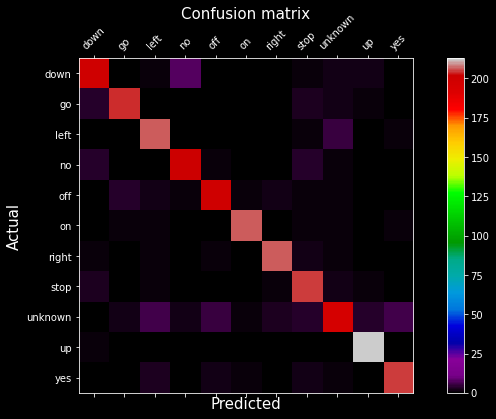

In [0]:
# plot confusion matrix
plt.figure(figsize=(12, 6))
plt.matshow(df_confusion, fignum=1, cmap="nipy_spectral") # gist_stern
plt.title("Confusion matrix", fontsize=15, x=0.5, y=1.1)
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name, fontsize=15)
plt.xlabel(df_confusion.columns.name, fontsize=15)
plt.savefig("confusion_test_matrix.png", bbox_inches='tight', 
            pad_inches=0.2, transparent=False)
